In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import git
import seaborn as sns
import nltk
import re
import urlextract
import unicodedata
import sklearn.metrics as metrics
import spacy
%matplotlib inline

from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

from sklearnex import patch_sklearn
from sklearnex.svm import SVC
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
repo_url = "https://github.com/roneysco/Fake.br-Corpus.git"

if not os.path.exists("fake_br"):
    repo = git.Repo.clone_from(repo_url, "fake_br")

In [4]:
folder = r'fake_br/full_texts/'

In [5]:
def extract_data(data_path, label):
    dir_data = glob(data_path + label + '/*.txt')
    array = []

    # Capturando dados das notícias
    for path in tqdm(dir_data):
        with open(path, encoding='utf-8') as file:
            text = file.read()
        array.append([text, label])   
         
    return array

In [6]:
fake_news = extract_data(folder, 'fake')
true_news = extract_data(folder, 'true')
fake_br = np.array(fake_news + true_news)

  0%|          | 0/3600 [00:00<?, ?it/s]

  0%|          | 0/3600 [00:00<?, ?it/s]

In [7]:
fake_br[0]

array(['Kátia Abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar.\t\n\nA senadora Kátia Abreu (sem partido-TO) disse que sua expulsão do PMDB foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista.\n\n“Amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. Essas pessoas que me expulsaram não servem ao país. Eles se servem do país em seus benefícios próprios”, disse Kátia Abreu.\n\nUé, mas se a expulsão é algo tão bom para seu currículo, por que tanta choradeira, Kátia?\n\nSabemos o motivo. Provavelmente Kátia não tem valor para o PT, partido que já deveria tê-la absorvido. Ao que parece o PT gostava de Kátia somente se ela ficasse entrincheirada dentro do PMDB.\n\nOu seja, isso é se rebaixar demais. Resta a Kátia ficar chorando as pitangas por todos os cantos.\n\nEm tempo: até o momento o PT não cadastrou Kátia Abreu em suas fileiras. Que situa

In [8]:
# def remove_invalid_chars(text):
#     # Cria uma lista com cada caractere da string
#     chars = list(text)

#     # Substitui os caracteres inválidos por espaço
#     valid_chars = [char if unicodedata.name(char, None) is not None else ' ' for char in chars]

#     # Junta os caracteres válidos de volta em uma string
#     return ''.join(valid_chars)

In [9]:
def remove_invalid_chars(text):
    # Cria uma lista com cada caractere da string
    chars = list(text)
    valid_chars = []
    last_char_valid = False

    for i, char in enumerate(chars):
        # Se o caractere for válido em UTF-8 ou for um espaço
        if unicodedata.name(char, None) is not None or char == ' ':
            valid_chars.append(char)
            last_char_valid = True
        # Se o caractere for inválido e a próxima e/ou a anterior não for um espaço, substitui por espaço
        elif (i > 0 and chars[i-1] != ' ') and (i+1 < len(chars) and chars[i+1] != ' '):
            if last_char_valid:
                valid_chars.append(' ')
            last_char_valid = False
        else:
            last_char_valid = False
            
    # Junta os caracteres válidos de volta em uma string
    return ''.join(valid_chars)


In [10]:
fake_br[0][0]

'Kátia Abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar.\t\n\nA senadora Kátia Abreu (sem partido-TO) disse que sua expulsão do PMDB foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista.\n\n“Amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. Essas pessoas que me expulsaram não servem ao país. Eles se servem do país em seus benefícios próprios”, disse Kátia Abreu.\n\nUé, mas se a expulsão é algo tão bom para seu currículo, por que tanta choradeira, Kátia?\n\nSabemos o motivo. Provavelmente Kátia não tem valor para o PT, partido que já deveria tê-la absorvido. Ao que parece o PT gostava de Kátia somente se ela ficasse entrincheirada dentro do PMDB.\n\nOu seja, isso é se rebaixar demais. Resta a Kátia ficar chorando as pitangas por todos os cantos.\n\nEm tempo: até o momento o PT não cadastrou Kátia Abreu em suas fileiras. Que situação pat

In [11]:
remove_invalid_chars(fake_br[0][0])

'Kátia Abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar. A senadora Kátia Abreu (sem partido-TO) disse que sua expulsão do PMDB foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista. “Amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. Essas pessoas que me expulsaram não servem ao país. Eles se servem do país em seus benefícios próprios”, disse Kátia Abreu. Ué, mas se a expulsão é algo tão bom para seu currículo, por que tanta choradeira, Kátia? Sabemos o motivo. Provavelmente Kátia não tem valor para o PT, partido que já deveria tê-la absorvido. Ao que parece o PT gostava de Kátia somente se ela ficasse entrincheirada dentro do PMDB. Ou seja, isso é se rebaixar demais. Resta a Kátia ficar chorando as pitangas por todos os cantos. Em tempo: até o momento o PT não cadastrou Kátia Abreu em suas fileiras. Que situação patética para a ex-mini

In [12]:
def preprocessing(database, remove_stopwords = True, remove_sc = True):
    data, label = database[:, 0], database[:, 1]

    pattern_words = re.compile(r'[a-zà-ÿ-]+') if remove_sc else re.compile(r'[a-zà-ÿ- .,?!();:]+')
    # print(pattern_words)
    # pattern_words = re.compile(r'\b\w+\b')
    extractor = urlextract.URLExtract()
    preprocessed_texts = []

    for text in tqdm(data):
        text = text.lower()
        text = remove_invalid_chars(text)
        text = re.sub(r'["\']', '', text)
        text = ' '.join([word for word in text.split() if not extractor.has_urls(word)])
        # text = re.sub(pattern_words, '', text)
        # tokens = nltk.word_tokenize(text)
        tokens = pattern_words.findall(text)
        if remove_stopwords:
            stopwords = set(nltk.corpus.stopwords.words("portuguese"))
            tokens = [token for token in tokens if token not in stopwords]
        preprocessed_texts.append(' '.join(tokens))

    return preprocessed_texts, label

In [13]:
news, y = preprocessing(fake_br, remove_stopwords=False, remove_sc=False)

  0%|          | 0/7200 [00:00<?, ?it/s]

In [48]:
news[0]

'kátia abreu diz que vai colocar sua expulsão em uma moldura, mas não para de reclamar. a senadora kátia abreu (sem partido-to) disse que sua expulsão do pmdb foi resultado de uma ação da cúpula atual da legenda que, segundo ela, é oportunista.  amanhã eu vou botar numa moldura dourada a minha expulsão, porque das mãos de onde veio, é um atestado de boa conduta para o meu currículo. essas pessoas que me expulsaram não servem ao país. eles se servem do país em seus benefícios próprios , disse kátia abreu. ué, mas se a expulsão é algo tão bom para seu currículo, por que tanta choradeira, kátia? sabemos o motivo. provavelmente kátia não tem valor para o pt, partido que já deveria tê-la absorvido. ao que parece o pt gostava de kátia somente se ela ficasse entrincheirada dentro do pmdb. ou seja, isso é se rebaixar demais. resta a kátia ficar chorando as pitangas por todos os cantos. em tempo: até o momento o pt não cadastrou kátia abreu em suas fileiras. que situação patética para a ex-mini

In [15]:
nlp = spacy.load('pt_core_news_sm')

In [16]:
def lematize(texts):
    lemmas = []
    # lemmatization_errors = []

    for text in tqdm(nlp.pipe(texts), total=len(texts)):
        doc = nlp(text)
        doc_lemmas = []
        for token in doc:
            if token.ent_type_ != "":
                doc_lemmas.append(token.text)
            else:
                lemma = token.lemma_
                # if lemma == token.text and lemma not in lemmatization_errors:
                #     # A palavra não foi lematizada corretamente
                #     lemmatization_errors.append(token.text)
                doc_lemmas.append(lemma)
        lemmas.append(' '.join(doc_lemmas))
    
    return lemmas

    # Adicionar os lemas dos tokens não-entidades ao resultado
    # if doc.is_parsed:
    #     lemmas.append([token.lemma_ if token.ent_type_ == '' else token.text for token in doc])

0it [00:00, ?it/s]

In [20]:
X = lematize(news)

In [21]:
X[0]

'kátia abreu dizer que ir colocar seu expulsão em um moldura , mas não para de reclamar . o senadora kátia abreu ( sem partido-to ) dizer que seu expulsão de o pmdb ser resultado de um ação de o cúpula atual de o legenda que , segundo ela , ser oportunista .   amanhã eu ir botar em um moldura dourar o meu expulsão , porque de o mão de onde vir , ser um atestado de bom conduta para o meu currículo . esse pessoa que eu expulsar não servir a o país . eles se servir de o país em seu benefício próprio , dizer kátia abreu . ué , mas se o expulsão ser algo tão bom para seu currículo , por que tanto choradeira , kátir ? saber o motivo . provavelmente kátia não ter valor para o pt , partido que já dever tê-la absorvir . a o que parecer o pt gostar de kátia somente se ele ficar entrincheirar dentro de o pmdb . ou ser , isso ser se rebaixar demais . restar o kátia ficar chorar o pitanga por todo o canto . em tempo : até o momento o pt não cadastrar kátia abreu em seu fileira . que situação patéti

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 42, 
                                                    test_size = 0.2, 
                                                    stratify = y)

In [23]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_train, y_test = y_train.reshape(-1), y_test.reshape(-1)

In [24]:
stopwords = nltk.corpus.stopwords.words("portuguese")
vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 4), use_idf=True, min_df=0.01, max_df=0.5)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
idf = vectorizer.idf_
feature_names = vectorizer.get_feature_names_out()

In [49]:
feature_names.shape

(5158,)

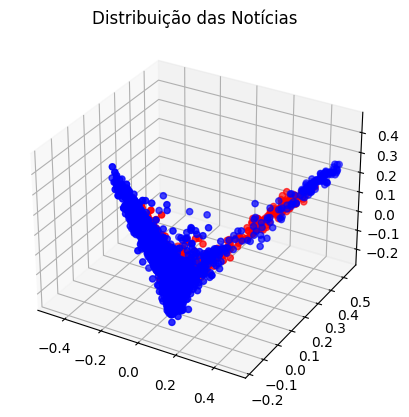

In [26]:
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train.toarray())

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_pca[y_train==0, 0], X_train_pca[y_train==0, 1], X_train_pca[y_train==0, 2], c='red', label='Fake News')
ax.scatter(X_train_pca[y_train==1, 0], X_train_pca[y_train==1, 1], X_train_pca[y_train==1, 2], c='blue', label='True News')
ax.set_title("Distribuição das Notícias")
plt.show()

In [51]:
model = SVC(kernel = 'rbf', probability = True, max_iter=1000)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9680555555555556

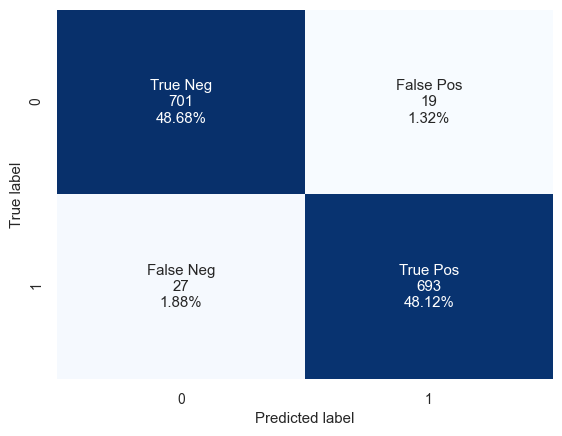

In [52]:
# create confusion matrix and labels
cm = confusion_matrix(y_test, model.predict(X_test))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

# create heatmap with adjusted font size
sns.set(font_scale=0.9)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False)

# add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()